# Quantum Chemistry: Robust Phase Estimation
## Simulate the dissociation curve (energy vs. bond length) for a $H_2$ molecule

In [1]:
import qsharp

In [2]:
qsharp.reload()

Reloading workspace.

In [3]:
from qsharp.chemistry import load_broombridge, load_fermion_hamiltonian, load_input_state, encode

Adding package microsoft.quantum.chemistry.jupyter.

## 1. Load computed $H_2$  from file
To generate:

1. Go to: https://arrows.emsl.pnnl.gov/api/qsharp_chem

2. Enter `HH theory{qsharp_chem}`

3. Under Datafiles, click "download"

In [4]:
import qsharp
from qsharp.chemistry import load_broombridge, load_fermion_hamiltonian, load_input_state, encode

filename = 'data/hydrogen_0.2.yaml'
broombridge_data =  load_broombridge(filename)
problem_description = broombridge_data.problem_description[0]
ferm_hamiltonian = problem_description.load_fermion_hamiltonian()
input_state = load_input_state(filename, "UCCSD |G>")
num_qubits, hamiltonian_term_list, input_state_terms, energy_offset = encode(ferm_hamiltonian, input_state)

### Hamiltonian terms
## $H = \sum_{pq}{h_{pq}} a_p^{\dagger}a_q^{\dagger} + \frac{1}{2} \sum_{pqrs}{h_{pqrs}} a_p^{\dagger}a_q^{\dagger}a_{r}a_{s}$

In [5]:
import pprint as pp
pp.pprint(hamiltonian_term_list)

([([0], [0.17120128499999998]),
  ([1], [0.17120128499999998]),
  ([2], [-0.222796536]),
  ([3], [-0.222796536])],
 [([0, 1], [0.1686232915]),
  ([0, 2], [0.12054614575]),
  ([0, 3], [0.16586802525]),
  ([1, 2], [0.16586802525]),
  ([1, 3], [0.12054614575]),
  ([2, 3], [0.1743495025])],
 [],
 [([0, 1, 2, 3], [0.0, -0.0453218795, 0.0, 0.0453218795])])


### Input trial state terms
## $T(\vec{\theta}) = \sum_{ij} \theta_{ij} a_{i}^{\dagger} a_{j} + \theta_{ijkl} a_{i}^{\dagger} a_{j}^{\dagger} a_{k} a_{l}$

In [6]:
pp.pprint(input_state_terms)

(3,
 [((0.001, 0.0), [2, 0]),
  ((-0.001, 0.0), [3, 1]),
  ((0.113, 0.0), [2, 3, 1, 0]),
  ((1.0, 0.0), [0, 1])])


## 2. Import Q# library operation
We can import the wrapper for any Q# operation of our project directly into our Python namespace.

In [7]:
from Test.Hydrogen import GetEnergyByTrotterization

In [8]:
GetEnergyByTrotterization

<Q# callable Test.Hydrogen.GetEnergyByTrotterization>

## 3. Quantum simulation

### Resource estimation

Estimate quantum resources required to run this algorithm.

In [9]:
GetEnergyByTrotterization.estimate_resources(JWEncodedData=(num_qubits, hamiltonian_term_list, input_state_terms, energy_offset), nBitsPrecision=7, trotterStepSize=0.4, trotterOrder=1)

{'CNOT': 99648,
 'QubitClifford': 50186,
 'R': 43736,
 'Measure': 317,
 'T': 0,
 'Depth': 0,
 'Width': 5,
 'BorrowedWidth': 0}

### General simulation
Simulate the operation using `.simulate()`.

In [10]:
phase, energy = GetEnergyByTrotterization.simulate(JWEncodedData=(num_qubits, hamiltonian_term_list, input_state_terms, energy_offset), nBitsPrecision=7, trotterStepSize=0.4, trotterOrder=1)

print(f"Phase: {phase}, Energy: {energy}")

Phase: -0.4099982804142568, Energy: -1.1238301470356422


In [11]:
# Print difference with exact FCI value known for this bond length
fci_value = -1.1372704220924401
print("Difference with exact FCI value: ", abs(energy - fci_value))

Difference with exact FCI value:  0.013440275056797901


## 4. Calculate one and two-electron integrals using PySCF for a given bond length

To specify the Hamiltonian of our electronic structure problem, we need to compute the coefficients by the one and two-electron integrals. These are relatively easy and fast to calculate. The difficult part is evaluating the ground state energy, which is the part we'll evaluate on a quantum computer.

In [12]:
from problem_description import create_H2_molecule, compute_integrals, updated_problem_description
from pyscf import scf, fci

In [13]:
# First, create a molecule with a given bond length.
molecule = create_H2_molecule(bond_length=1.624/1.88973)
# Calculate using 
RHF = scf.RHF(molecule)
RHF.scf()
energy_nuc = RHF.energy_nuc()
one_el, two_el = compute_integrals(problem_description, molecule, RHF)
one_el, two_el, energy_nuc

converged SCF energy = -1.10067441313401


([([1, 1], -1.184281), ([2, 2], -0.538244)],
 [([1, 1, 1, 1], 0.652123),
  ([1, 2, 2, 1], 0.188121),
  ([1, 1, 2, 2], 0.643609),
  ([2, 2, 2, 2], 0.676401)],
 0.6157648096008939)

### Get FCI energy for direct comparison with RPE

When you are doing RPE, you are getting FCI energy, which is the exact solution of the Schrodinger equation in a finite basis. (Hartree-Fock is the mean-field approximation solution). PySCF also lets us calculate the FCI energy.

In [14]:
cisolver = fci.FCI(RHF)
fci_energy = cisolver.kernel()[0]
print('E(FCI) = %.12f' % fci_energy)

E(FCI) = -1.127031225401


### Use this as input to the Q# algorithm and simulate

In [15]:
new_pd = updated_problem_description(filename, one_el, two_el, energy_nuc)
ferm_hamiltonian = new_pd.load_fermion_hamiltonian()
jw_encoded_data = encode(ferm_hamiltonian, input_state)
phase, energy = GetEnergyByTrotterization.simulate(JWEncodedData=jw_encoded_data, nBitsPrecision=7, trotterStepSize=0.4, trotterOrder=1)

print(f"Phase: {phase}, Energy: {energy}")

Phase: -0.36091089520191627, Energy: -1.1273579284038968


## 5. Run Robust Phase Estimation for varying bond length

Now, we will take everything we've done and run it in a for-loop to calculate the energy for a list of bond lengths. 

In [16]:
import numpy as np
from trotterization import robust_phase_estimation

In [17]:
energy = []
calculated_energy = []
all_results = []
bond_lengths = np.arange(0.4,1.7,0.1)
filename = "data/hydrogen_0.2.yaml"
num_iterations = 3
broombridge_data = load_broombridge(filename)
input_state = load_input_state(filename, "UCCSD |G>")
problem_description = broombridge_data.problem_description[0]

for bond_length in bond_lengths:
    molecule = create_H2_molecule(bond_length=bond_length)
    RHF = scf.RHF(molecule)
    RHF.scf()
    cisolver = fci.FCI(RHF)
    fci_energy = cisolver.kernel()[0]
    energy_nuc = RHF.energy_nuc()
    one_el, two_el = compute_integrals(problem_description, molecule, RHF)
    new_pd = updated_problem_description(filename, one_el, two_el, energy_nuc)
    ferm_hamiltonian = new_pd.load_fermion_hamiltonian()
    jw_encoded_data = encode(ferm_hamiltonian, input_state)

    results = [robust_phase_estimation(*jw_encoded_data) for _ in range(num_iterations)]
    all_results.append(results)
    _energy = min(results)
    energy.append(_energy)
    calculated_energy.append(fci_energy)

converged SCF energy = -0.904361394163539
converged SCF energy = -1.04299627454009
converged SCF energy = -1.1011282422677
converged SCF energy = -1.11734903499028
converged SCF energy = -1.11085039747659
converged SCF energy = -1.09191404102006
converged SCF energy = -1.06610864931794
converged SCF energy = -1.03653887502918
converged SCF energy = -1.00510670656849
converged SCF energy = -0.973110615777578
converged SCF energy = -0.941480654707798
converged SCF energy = -0.910873554594386
converged SCF energy = -0.881732449946057


Text(0, 0.5, 'Energy (Ha)')

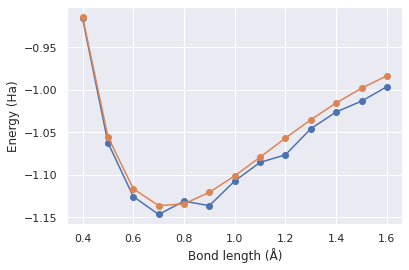

In [18]:
import matplotlib as mpl
import seaborn as sns
import pylab as pl
%matplotlib inline
sns.set_theme(style="darkgrid")

pl.plot(bond_lengths, [en for _, en in energy], "o-")
pl.plot(bond_lengths, calculated_energy, "o-")

pl.xlabel("Bond length (Å)")
pl.ylabel("Energy (Ha)")